In [2]:
import numpy as np
import theano
import theano.tensor as T

# Pseudocódigo de predição

```
predict(x)
    wx_bias = self.w.x + self.bias
    return self.activation(wx_bias), wx_bias
    
self.activation = signal
```

# Pseudocódigo da signal

```
signal(value)
    boolean_value = value>0
    return 2*boolean_value-1
```

# Pseudocódigo do custo

```
custo(wx_bias,y)
    return abs(wx_bias-y)/2
```

# Pseudocódigo do treinamento

```
fit(x,y,max)
    error <- 1
    count <- 0
    while error > 0 and count < max
        error <- 0
        count <- count + 1
        for (_x,_y) in dataset
            wx_bias <- self.predict(x)
            local_error <- self.cost(wx_bias,y)
            self.update_weights(x,y,local_error)
            error <- error + local_error
```

# Pseudocódigo de atualização de pesos

```
update_weights(x,y,local_error)
    self.w <- self.w + x*y*local_error
    self.bias <- self.bias + y*local_error
```

Onde:

* $W$ é o vetor de pesos.

* $bias$ é o bias.

* $x$ é o vetor de entrada

* $y$ é o valor esperado

* $\hat{y}$ é o valor calculado




In [25]:
def signal(value):
    return 2*(T.gt(value,0))-1

class Perceptron(object):
    
    def __init__(self,x_example,activation,initial_value=0.):
        W = np.zeros_like(x_example) + initial_value
        bias = np.float32(initial_value)
        self.W = theano.shared(W,name="W")
        self.x_input = T.fvector(name="x_input")
        self.y_input = T.fscalar(name="y_input")
        self.bias = theano.shared(bias,name="bias")

        ### PREDIÇÃO
        self.wx_bias = self.W.dot(self.x_input) + self.bias
        self.y_chapeu = activation(self.wx_bias)
        self.predict = theano.function(
            inputs=[self.x_input],
            outputs=[self.y_chapeu]) 

        ### CUSTO
        error = 1-self.wx_bias*self.y_input
        self.local_error = T.maximum(0,error) # Derivada do theano pro T.maximum é um pouco diferente.
                                     

        ### GRADIENTE E UPDATES
        self.w_grad, self.bias_grad = T.grad(
            self.local_error, [self.W, self.bias]) 
        #Calculo da derivada do erro, baseado em W e bias
        self.new_W = self.W - self.w_grad
        self.new_bias = self.bias - self.bias_grad

        ### FUNÇÃO FIT
        self.fit_theano = theano.function(
            inputs=[self.x_input, self.y_input], 
            outputs=[self.y_chapeu,self.local_error],
            updates=[
                     (self.W,self.new_W),
                     (self.bias,self.new_bias)
                    ]
            )
    def fit(self,x,y,_max=1000):
        error = 1
        count = 0
        while error > 0 and count < _max:
            error = 0
            count += 1
            for _x,_y in zip(x,y):
                y_chapeu, local_error = self.fit_theano(_x,_y)
                error += local_error[0]
        return error == 0, count

# Criação dos datasets

Dataset binário para AND, OR e XOR

In [26]:
possible_x = np.array(
    [[0,0],[0,1],[1,0],[1,1]],dtype=np.float32)

dataset_and = dict(x=possible_x,y=np.array([-1,-1,-1,1]))
dataset_or = dict(x=possible_x,y=np.array([-1,1,1,1]))
dataset_xor = dict(x=possible_x,y=np.array([-1,1,1,-1]))

# Teste para o and

In [27]:
and_perceptron = Perceptron(dataset_and["x"][0],signal)
result = and_perceptron.fit(**dataset_and)
result, and_perceptron.W.get_value(), and_perceptron.bias.get_value()

((True, 12), array([ 5.,  4.], dtype=float32), array(-5.0, dtype=float32))

# Teste para o or

In [13]:
or_perceptron = Perceptron(dataset_or["x"][0],signal)
result = or_perceptron.fit(**dataset_or)
result, or_perceptron.W.get_value(), or_perceptron.bias.get_value()

((True, 8), array([ 3.,  4.], dtype=float32), array(-1.0, dtype=float32))

# Teste para o xor

In [14]:
xor_perceptron = Perceptron(dataset_xor["x"][0],signal)
result = xor_perceptron.fit(**dataset_xor)
result, xor_perceptron.W.get_value(), xor_perceptron.bias.get_value()

((False, 1000), array([ 0.,  0.], dtype=float32), array(0.0, dtype=float32))

O xor é impossível com os dados atuais pois temos uma impossibilidade lógica

<center> $x = [0,0]$ $y = -1$. <b>Logo</b> $bias \leq 0$</center>
<center> $x = [1,0]$ $y = 1$. <b>Logo</b> $-bias \leq W[0] $</center>
<center> $x = [0,1]$ $y = 1$. <b>Logo</b> $-bias \leq W[1] $</center>
<center> $x = [1,1]$ $y = -1$. <b>Logo</b> $W[0] + W[1] \leq -bias$</center>

<center>$bias \leq 0 \implies |bias| = - bias$  </center>

<center>Então

$$ |bias| \leq W[0] \implies W[0] \geq 0 $$
$$ |bias| \leq W[1] \implies W[1] \geq 0$$
$$ W[0] + W[1] \leq |bias|$$

logo

$$ W[0] \geq |bias| \land W[1] \geq |bias| \land W[0] + W[1] \leq |bias| $$

<h1>Impossível</h1>
</center>

## Solução?

Para resolvermos esse problema vamos adicionar um valor para a entrada que é o valor do and entre os dois valores de entrada. Feito isso teremos:

<center> $x = [0,0,0]$ $y = -1$. <b>Logo</b> $bias \leq 0$</center>
<center> $x = [1,0,0]$ $y = 1$. <b>Logo</b> $-bias \leq W[0] $</center>
<center> $x = [0,1,0]$ $y = 1$. <b>Logo</b> $-bias \leq W[1] $</center>
<center> $x = [1,1,1]$ $y = -1$. <b>Logo</b> $W[0] + W[1] + W[2] \leq -bias$</center>

<center>$bias \leq 0 \implies |bias| = - bias$  </center>

<center>Então

$$ |bias| \leq W[0] \implies W[0] \geq 0 $$
$$ |bias| \leq W[1] \implies W[1] \geq 0$$
$$ W[0] + W[1] + W[2] \leq |bias|$$

logo

$$ W[0] \geq |bias| \land W[1] \geq |bias| \land W[2] \leq |bias| - |W[0]| - |W[1]| $$

<h1>Não impossível</h1>
</center>

In [15]:
dataset_xor = dict(
    x=np.array([[0,0,0],[0,1,0],[1,0,0],[1,1,1]],
               dtype=np.float32),
    y=dataset_xor["y"])

xor_perceptron = Perceptron(dataset_xor["x"][0],signal)
result = xor_perceptron.fit(**dataset_xor)
result, xor_perceptron.W.get_value(), xor_perceptron.bias.get_value()

((True, 16), array([ 3.,  4., -8.], dtype=float32), array(-1.0, dtype=float32))

In [16]:
print(theano.printing.pprint(xor_perceptron.y_chapeu) )

((TensorConstant{2} * gt(((W \dot x_input) + bias), TensorConstant{0})) - TensorConstant{1})


In [17]:
theano.printing.debugprint(xor_perceptron.predict)  

Elemwise{Composite{(i0 + (i1 * GT((i2 + i3), i4)))}} [id A] ''   4
 |TensorConstant{-1} [id B]
 |TensorConstant{2} [id C]
 |InplaceDimShuffle{} [id D] ''   3
 | |CGemv{inplace} [id E] ''   2
 |   |AllocEmpty{dtype='float32'} [id F] ''   1
 |   | |TensorConstant{1} [id G]
 |   |TensorConstant{1.0} [id H]
 |   |InplaceDimShuffle{x,0} [id I] ''   0
 |   | |x_input [id J]
 |   |W [id K]
 |   |TensorConstant{0.0} [id L]
 |bias [id M]
 |TensorConstant{0} [id N]


The output file is available at pics/predição.png


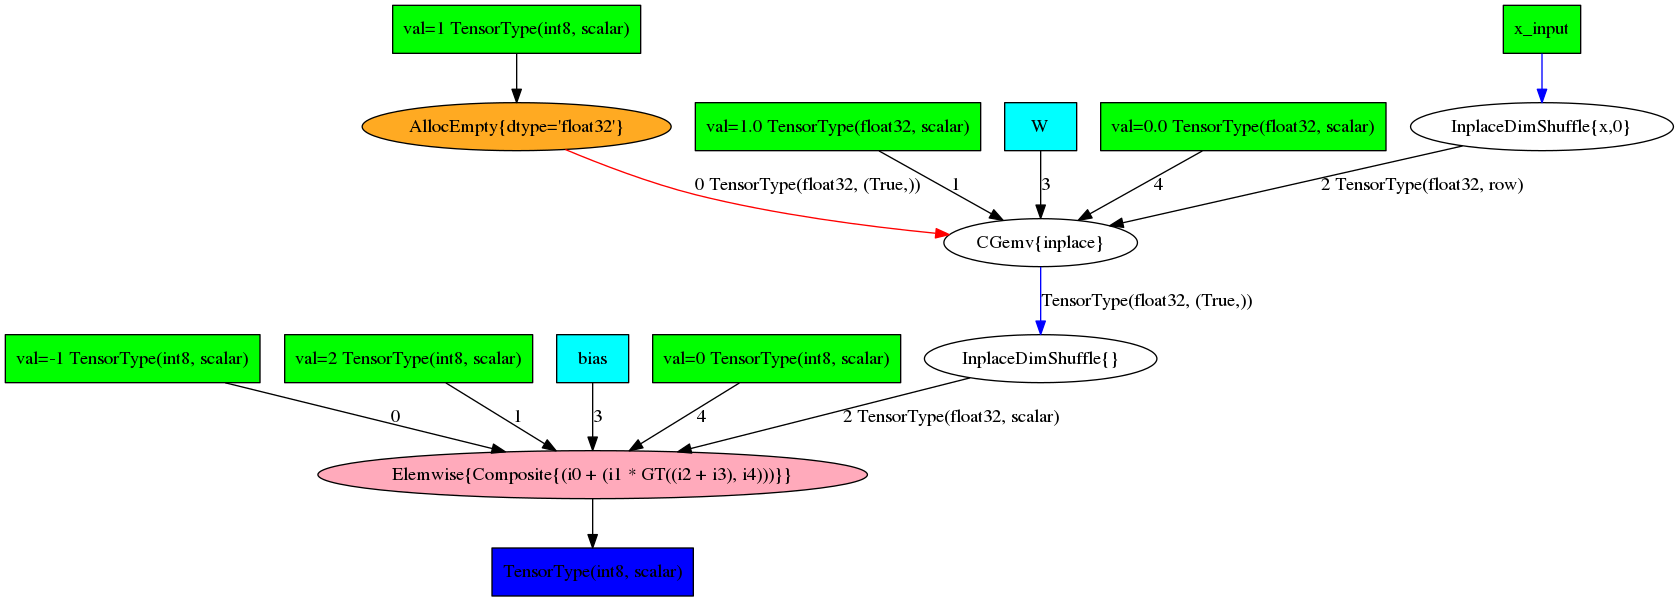

In [18]:
from IPython.display import Image
theano.printing.pydotprint(xor_perceptron.predict, outfile="pics/y_chapeu.png", var_with_name_simple=True)
Image('pics/y_chapeu.png', width='200%')


The output file is available at pics/treinamento.png


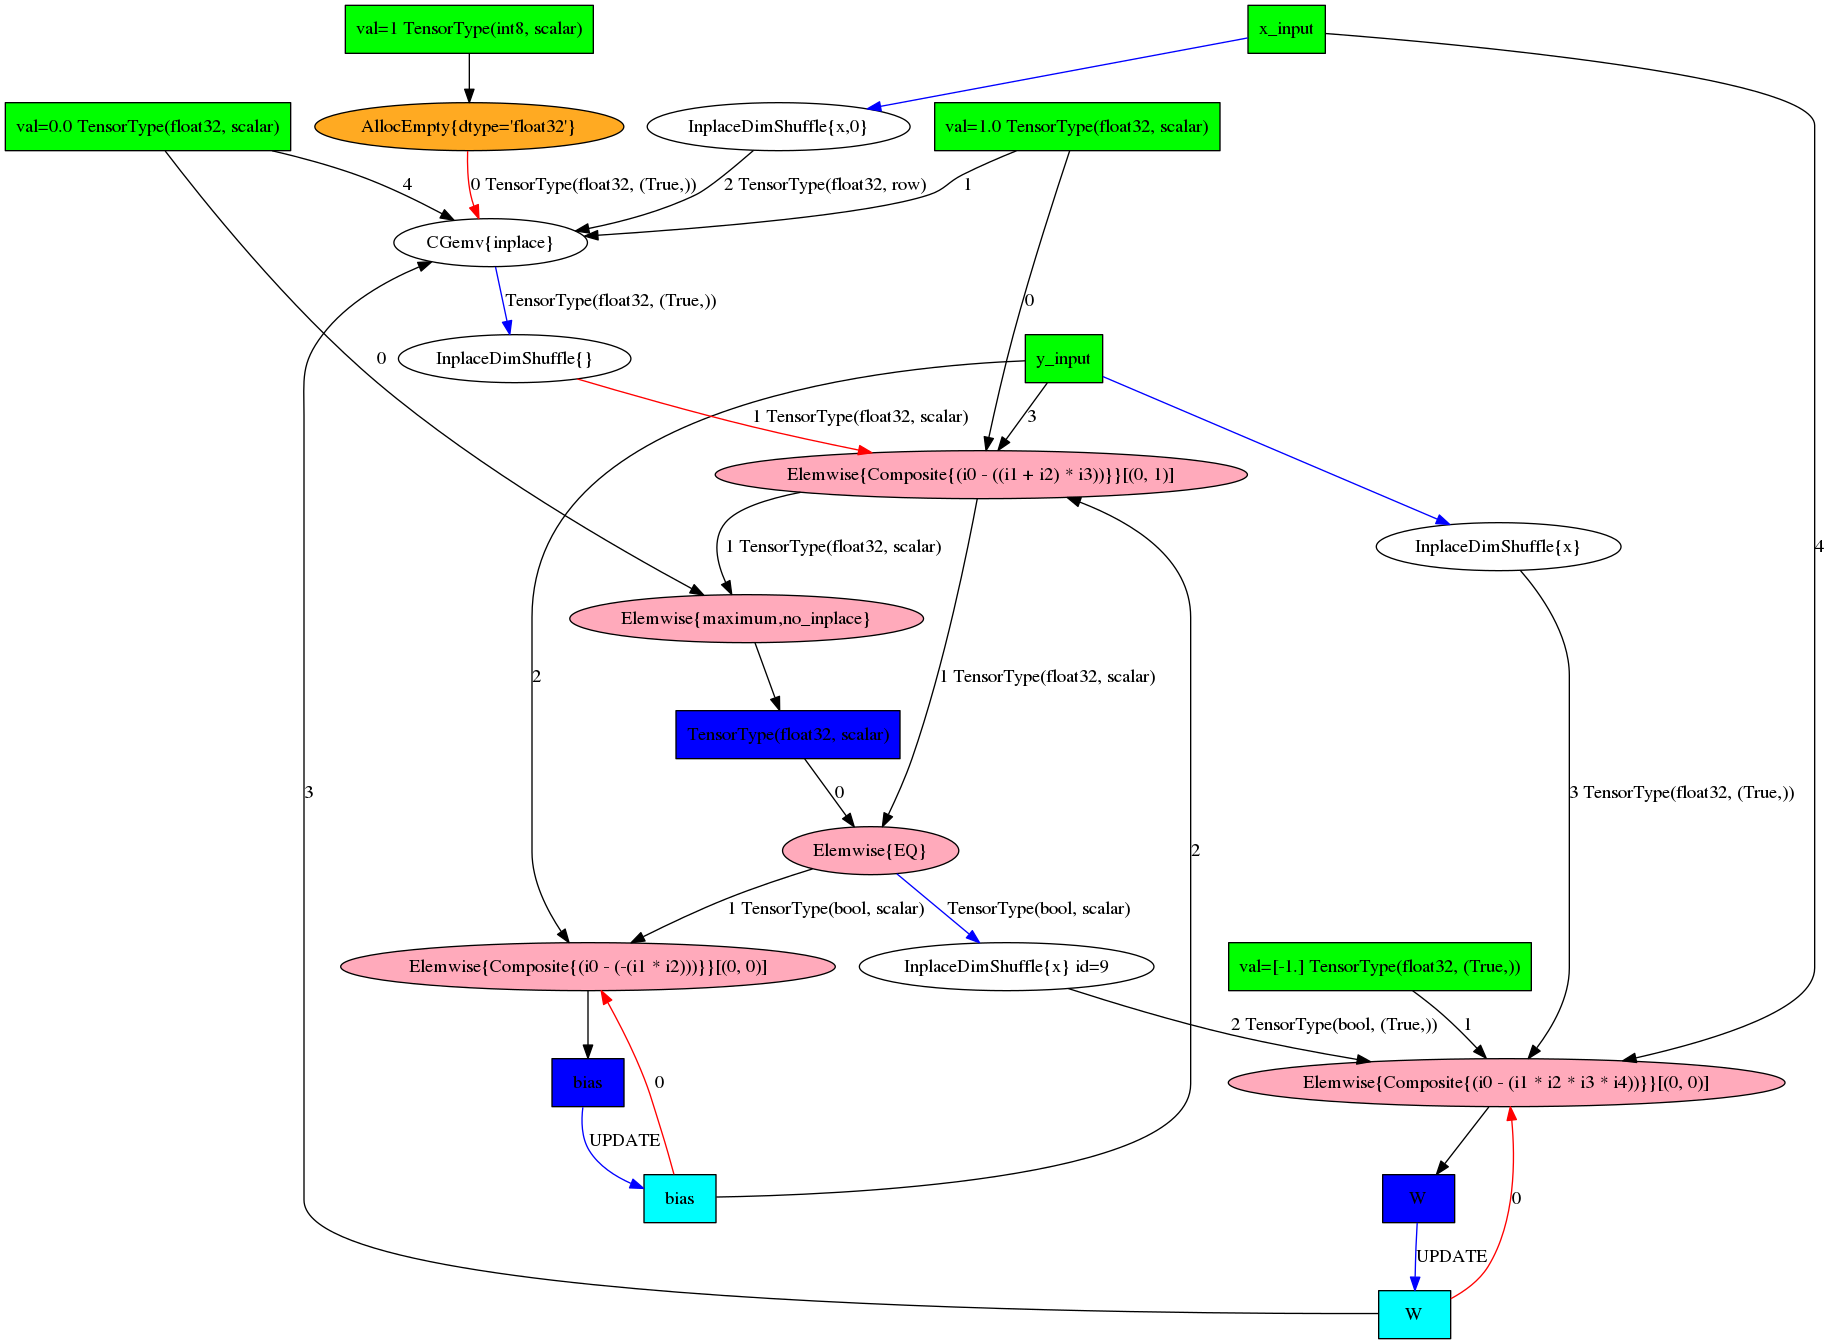

In [19]:
theano.printing.pydotprint(xor_perceptron.fit_theano, outfile="pics/treinamento.png", var_with_name_simple=True)
Image('pics/treinamento.png', width='200%')


In [20]:
x_example = dataset_and["x"][0]
initial_value = 0.1
W = np.zeros_like(x_example) + initial_value
bias = np.float32(initial_value)
W = theano.shared(W,name="W")
x_input = T.fvector(name="x_input")
y_input = T.fscalar(name="y_input")
bias = theano.shared(bias,name="bias")

wx_bias = W.dot(x_input)+ bias
y_chapeu = signal(wx_bias)

In [21]:
wx_bias.eval({x_input:[1,1]})
y_chapeu.eval({x_input:[-0.5,-0.5]})

array(-1, dtype=int8)